# RandomForest Regression Model To Forecast Weekly Sales

In [55]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tck
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import GridSearchCV, train_test_split

#### ETL

In [56]:
# Read input data
sales_df = pd.read_csv('Resources/walmart_cleaned.csv', index_col=0)
sales_df.tail(2)

,Store,Date,IsHoliday,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
423284,45,2012-10-26,0,83.0,717.82,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221
423285,45,2012-10-26,0,98.0,1076.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221


In [57]:
sales_df['Date'] = pd.to_datetime(sales_df['Date'])
sales_df['week_of_year'] = sales_df['Date'].dt.isocalendar().week
sales_df['year'] = sales_df['Date'].dt.year
sales_df['year_week'] = (sales_df['year'].astype(int) * 100) + sales_df['week_of_year'].astype(int)
sales_df.dtypes

Store                    int64
Date            datetime64[ns]
IsHoliday                int64
Dept                   float64
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                     int64
Size                     int64
week_of_year            UInt32
year                     int64
year_week                int32
dtype: object

In [58]:
# Add new columns to separate patterns
sales_df['IS_XMAS'] = 0
sales_df['IS_SUPERBOWL'] = 0
sales_df['IS_TGIVING'] = 0
sales_df['IS_LABORDAY'] = 0
# sales_df['IS_MEMORIALDAY'] = 0
# sales_df['IS_JULY4TH'] = 0
sales_df.loc[sales_df['week_of_year'] == 6, 'IS_SUPERBOWL'] = 1
# sales_df.loc[sales_df['week_of_year'] == 22, 'IS_MEMORIALDAY'] = 1
# sales_df.loc[sales_df['week_of_year'] == 27, 'IS_JULY4TH'] = 1
sales_df.loc[sales_df['week_of_year'] == 36, 'IS_LABORDAY'] = 1
sales_df.loc[sales_df['week_of_year'] == 47, 'IS_TGIVING'] = 1
sales_df.loc[sales_df['week_of_year'] == 52, 'IS_XMAS'] = 1

In [59]:
sales_df.columns

Index(['Store', 'Date', 'IsHoliday', 'Dept', 'Weekly_Sales', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size', 'week_of_year',
       'year', 'year_week', 'IS_XMAS', 'IS_SUPERBOWL', 'IS_TGIVING',
       'IS_LABORDAY'],
      dtype='object')

In [60]:
col_names = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'year_week', 'year',
             'IS_SUPERBOWL', 'IS_TGIVING', 'IS_XMAS', 'IS_LABORDAY', #'IS_MEMORIALDAY', 'IS_JULY4TH',
             'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
sales_df_grouped = sales_df.groupby(['Date', 'week_of_year'])[col_names].agg(
    {'Weekly_Sales': 'sum', 'Temperature': 'mean', 'Fuel_Price': 'mean', 'CPI': 'mean', 'Unemployment': 'mean', 'Size': 'mean', 'IS_XMAS': 'max',
     'IS_SUPERBOWL' : 'max', 'IS_TGIVING' : 'max', 'IS_LABORDAY' : 'max',  'year_week': 'max', 'year': 'max',
     'MarkDown1': 'mean', 'MarkDown2': 'mean', 'MarkDown3': 'mean', 'MarkDown4':'mean', 'MarkDown5':'mean'}
).reset_index()

In [61]:
mgroup = sales_df_grouped.groupby(['week_of_year'])[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].mean().reset_index()

<AxesSubplot:title={'center':'Regional Weekly Sales (Feb 2010 thru Oct 2012)'}, xlabel='Date', ylabel='Weekly Sales ($)'>

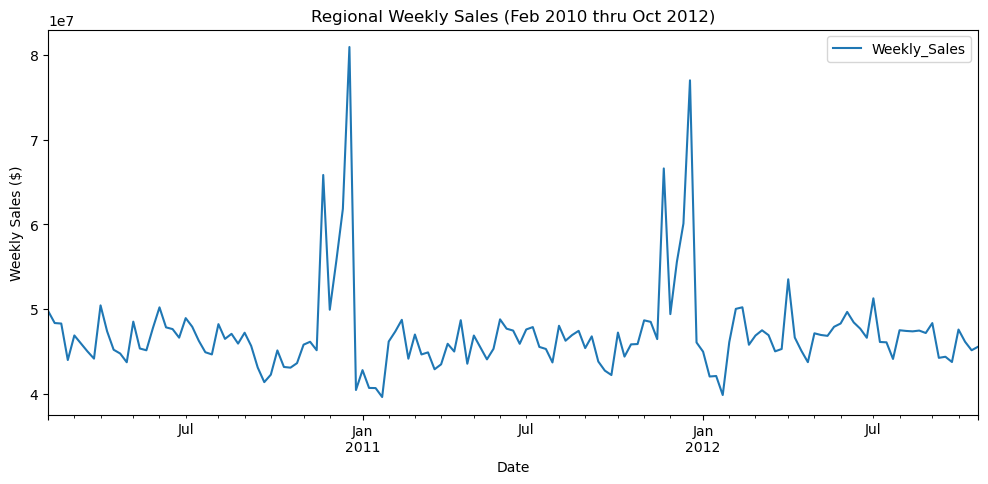

In [62]:
# Plot Grouped Weekly Sales 
sales_df_grouped.plot(x='Date', y='Weekly_Sales', title='Regional Weekly Sales (Feb 2010 thru Oct 2012)', 
                      ylabel='Weekly Sales ($)', figsize=(12, 5))

In [63]:
# # 2 new features added after groupby as week# is sorted. This is to account for spikes in Nov and Dec
sales_df_grouped['IS_NEAR_EASTER'] = 0
sales_df_grouped['IS_NEAR_TGIVING'] = 0
sales_df_grouped['IS_NEAR_XMAS'] = 0
sales_df_grouped.loc[sales_df_grouped['week_of_year'].between(44, 46, inclusive = 'neither'), 'IS_NEAR_TGIVING'] = 1
sales_df_grouped.loc[sales_df_grouped['week_of_year'].between(48, 52, inclusive = 'neither'), 'IS_NEAR_XMAS'] = 1

# # Week before Easter has high sales and Easter varies each year - so setting the corresponding week before Easter per year
sales_df_grouped.loc[sales_df_grouped['year_week'].between(201012, 201014, inclusive = 'neither'), 'IS_NEAR_EASTER'] = 1
sales_df_grouped.loc[sales_df_grouped['year_week'].between(201115, 201117, inclusive = 'neither'), 'IS_NEAR_EASTER'] = 1
sales_df_grouped.loc[sales_df_grouped['year_week'].between(201213, 201216, inclusive = 'neither'), 'IS_NEAR_EASTER'] = 1

In [64]:
for index, row in mgroup.iterrows():
    sales_df_grouped.loc[sales_df_grouped['week_of_year'] == (index + 1), 'MarkDown1'] = row['MarkDown1']
    sales_df_grouped.loc[sales_df_grouped['week_of_year'] == (index + 1), 'MarkDown2'] = row['MarkDown2']
    sales_df_grouped.loc[sales_df_grouped['week_of_year'] == (index + 1), 'MarkDown3'] = row['MarkDown3']
    sales_df_grouped.loc[sales_df_grouped['week_of_year'] == (index + 1), 'MarkDown4'] = row['MarkDown4']
    sales_df_grouped.loc[sales_df_grouped['week_of_year'] == (index + 1), 'MarkDown5'] = row['MarkDown5']

In [65]:
sales_df_grouped.head()

,Date,week_of_year,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,Size,IS_XMAS,IS_SUPERBOWL,...,year_week,year,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IS_NEAR_EASTER,IS_NEAR_TGIVING,IS_NEAR_XMAS
0,2010-02-05,5,49750740.50,33.277942,2.717869,167.398405,8.576731,137430.535364,0,0,...,201005,2010,12772.742339,1000.563580,50.224303,10169.260062,2080.410287,0,0,0
1,2010-02-12,6,48336677.63,33.361810,2.696102,167.384138,8.567309,137622.780785,0,1,...,201006,2010,3763.302805,1527.148073,24.780070,3185.441663,2020.257550,0,0,0
2,2010-02-19,7,48276993.78,37.038310,2.673666,167.338966,8.576351,137278.637219,0,0,...,201007,2010,3870.768270,2766.499233,6.133291,2187.762072,2010.770164,0,0,0
3,2010-02-26,8,43968571.13,38.629563,2.685642,167.691019,8.561375,137346.344629,0,0,...,201008,2010,3145.102934,1976.096956,1.505183,961.942407,1961.545176,0,0,0
4,2010-03-05,9,46871470.30,42.373998,2.731816,167.727351,8.572689,137576.841033,0,0,...,201009,2010,5553.574279,534.503423,9.492087,3819.727613,1178.601564,0,0,0


In [66]:
# Add Weekly Sales lag (sort dataframe on year_week before shift)
sales_df_grouped = sales_df_grouped.sort_values('year_week')
sales_df_grouped['Weekly_Sales_Lag1'] = sales_df_grouped['Weekly_Sales'].shift(1)
sales_df_grouped['Weekly_Sales_Lag4'] = sales_df_grouped['Weekly_Sales'].shift(4)

# Drop rows with null values (caused by shift to include lag)
sales_df_grouped.dropna(inplace=True)

#### Preprocess - Split train and test datasets - Scale and Transform features

In [67]:
# Separate features and result
X = sales_df_grouped.copy()
x_axis = X['Date']
X.drop(columns=['Weekly_Sales', 'Date', 'year'], axis=1, inplace=True)
x_list = list(X.columns)

y = sales_df_grouped['Weekly_Sales'].ravel()

X.head(2)

,week_of_year,Temperature,Fuel_Price,CPI,Unemployment,Size,IS_XMAS,IS_SUPERBOWL,IS_TGIVING,IS_LABORDAY,...,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IS_NEAR_EASTER,IS_NEAR_TGIVING,IS_NEAR_XMAS,Weekly_Sales_Lag1,Weekly_Sales_Lag4
4,9,42.373998,2.731816,167.727351,8.572689,137576.841033,0,0,0,0,...,5553.574279,534.503423,9.492087,3819.727613,1178.601564,0,0,0,43968571.13,49750740.50
5,10,46.967143,2.774452,167.504162,8.580858,137105.960393,0,0,0,0,...,2777.753043,160.954761,1.889518,1025.726789,1579.440591,0,0,0,46871470.30,48336677.63


In [68]:
X.shape, y.shape

((139, 21), (139,))

In [69]:
# Split predictors into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Scale features
scaler = StandardScaler()

# Fit scaler
X_scaler = scaler.fit(X_train)

# Transform
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test) 

### Initialize RF Regressor, Train and Predict

In [70]:
# Initialize RandomForest Regressor
rf_model = RandomForestRegressor(n_estimators=1500, random_state=24)

# Fit the model with train set
rf_model.fit(X_train_scaled, y_train)

# Predict using test set
predictions = rf_model.predict(X_test_scaled)

# Get MSE, MAE, RMSE and r2_score of the test
mse_value = mean_squared_error(y_test, predictions)
mae_value = mean_absolute_error(y_test, predictions)
rmse_value = np.sqrt(mse_value)
r2s_value = r2_score(y_test, predictions)
    

# Save results
results = pd.DataFrame(data={ 'Actual_Sales': y_test, 'Predicted_Sales': predictions})

rpt_metrics = {'MSE': mse_value, 'MAE': mae_value, 'RMSE': rmse_value, 'R2_Score': r2s_value}

In [71]:
# Get count of result rows to get the corresponding dates to use in plot for x-axis values
count = results.shape[0] * -1

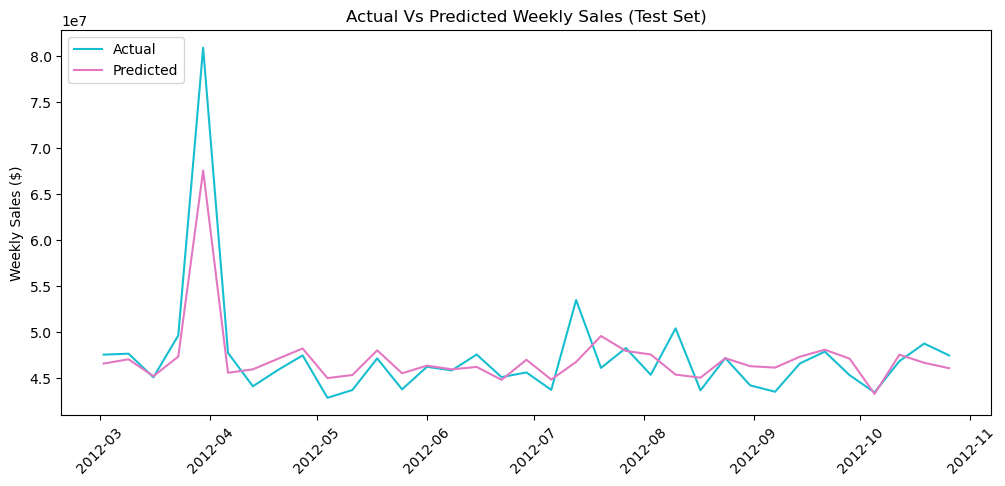

In [72]:
# Plot Trial1 results
plt.figure(figsize=(12,5))
plt.plot(x_axis[count:], results['Actual_Sales'], c='tab:cyan', label='Actual')
plt.plot(x_axis[count:], results['Predicted_Sales'], c='tab:pink', label='Predicted')
plt.xticks(rotation=45)
plt.ylabel('Weekly Sales ($)')
plt.legend(loc='upper left')
plt.title('Actual Vs Predicted Weekly Sales (Test Set)')

plt.savefig('Images/predictions.test.png', bbox_inches='tight')

In [73]:
# Print Statistics for the model    
print('=========================================================================')
print('Statistics from Test Predictions (Regional Weekly Sales of Walmart Stores')
print('=========================================================================')
print('Features used: ', x_list)
print('Mean Absolute Error (MAE):', rpt_metrics['MAE'])
print('Mean Squared Error (MSE):', round(rpt_metrics['MSE'],2))
print('\nRoot Mean Squared Error (RMSE):', rpt_metrics['RMSE'])
print('R2 Score:', rpt_metrics['R2_Score'])
print('===========================================================================')

Statistics from Test Predictions (Regional Weekly Sales of Walmart Stores
Features used:  ['week_of_year', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size', 'IS_XMAS', 'IS_SUPERBOWL', 'IS_TGIVING', 'IS_LABORDAY', 'year_week', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'IS_NEAR_EASTER', 'IS_NEAR_TGIVING', 'IS_NEAR_XMAS', 'Weekly_Sales_Lag1', 'Weekly_Sales_Lag4']
Mean Absolute Error (MAE): 1857435.4974084012
Mean Squared Error (MSE): 9206770826832.82

Root Mean Squared Error (RMSE): 3034266.1100887004
R2 Score: 0.7586321388948768


### Use model to predict for all years

In [74]:
X_all_scaled = scaler.transform(X)
predictions_full = rf_model.predict(X_all_scaled) 

# Get MSE, MAE, RMSE and r2_score of the test
mse_value = mean_squared_error(y, predictions_full)
mae_value = mean_absolute_error(y, predictions_full)
rmse_value = np.sqrt(mse_value)
r2s_value = r2_score(y, predictions_full)
    

# Save predictions
results_final = pd.DataFrame(data={ 'Date': x_axis, 'Actual_Sales': y, 'Predicted_Sales': predictions_full})

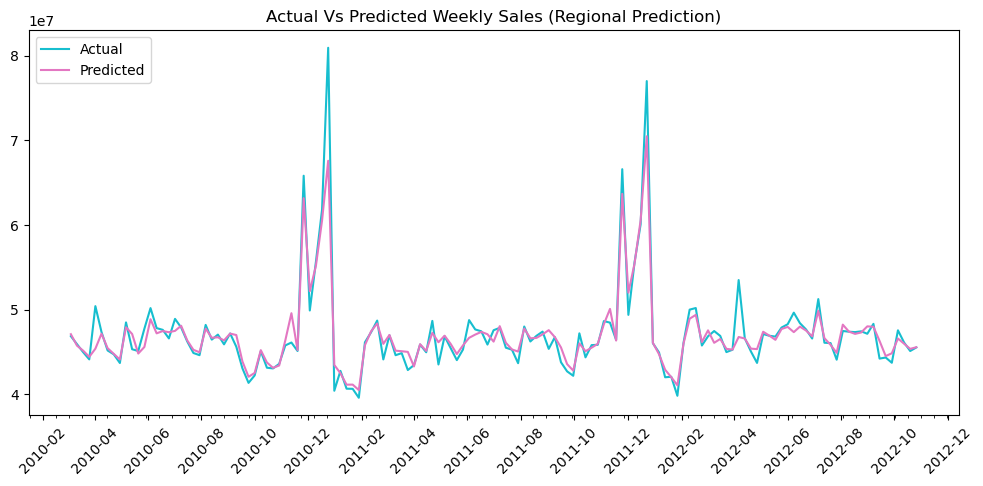

In [75]:
plt.figure(figsize=(12,5))
ax = plt.gca()
plt.plot(x_axis.ravel(), y, c='tab:cyan', label='Actual')
plt.plot(x_axis.ravel(), predictions_full, c='tab:pink', label='Predicted')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.title('Actual Vs Predicted Weekly Sales (Regional Prediction)')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

plt.savefig('Images/predictions_all.png', bbox_inches='tight')

In [76]:
# Print Statistics for the model    
print('=============================================================================')
print('Statistics from Overall Predictions (Regional Weekly Sales of Walmart Stores)')
print('=============================================================================')
print('Features used: ', ', '.join(x_list[:-5]))
print('Mean Absolute Error (MAE):', mae_value)
print('Mean Squared Error (MSE):', mse_value)
print('\nRoot Mean Squared Error (RMSE):', rmse_value)
print('R2 Score:', r2s_value)
print('=============================================================================')

Statistics from Overall Predictions (Regional Weekly Sales of Walmart Stores)
Features used:  week_of_year, Temperature, Fuel_Price, CPI, Unemployment, Size, IS_XMAS, IS_SUPERBOWL, IS_TGIVING, IS_LABORDAY, year_week, MarkDown1, MarkDown2, MarkDown3, MarkDown4, MarkDown5
Mean Absolute Error (MAE): 903690.2018261061
Mean Squared Error (MSE): 3104652752186.293

Root Mean Squared Error (RMSE): 1762002.483592544
R2 Score: 0.8969827102840046


### Save model as file for future use without training

In [ ]:
import pickle

pkl_filename = "rf_prediction_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf_model, file)


### Save predictions in csv and also in SQL DB

In [ ]:
# Save as csv
results_final.to_csv('Resources/final_predictions.csv', index=False)

### Save to SQL DB (MachineLearning) Table (sales_predictions)

In [ ]:
# Import dependencies for sql
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session
from sqlalchemy.orm import sessionmaker
from config import user_id, user_password

In [ ]:
# rename dataframe columns to match SQL table column names
results_final.rename(columns= {'Date': 'fiscal_weekend', 'Actual_Sales': 'actual_sales', 'Predicted_Sales': 'predicted_sales'}, inplace=True)

# connect to postgresql
db_name = 'MachineLearning'
table_name = 'sales_predictions'

conn_string = 'postgresql://' + user_id + ':' + user_password + '@localhost:5432/' + db_name
engine = create_engine(conn_string)

# Autoload table from database to build metadata
metadata = sqlalchemy.schema.MetaData(bind=engine)
table_inspect = sqlalchemy.Table(table_name, metadata, autoload=True, autoload_with=engine)

In [ ]:
# Create a Session Object to Connect to DB
# ----------------------------------------
Session = sessionmaker(bind=engine)

# Bulk Insert the dataframe into the database table (commit changes)
with Session() as session:        
    results_final.to_sql(table_name, con=engine, if_exists='replace', index=False)
    session.commit()

In [ ]:
# Explicit Close for safety
session.close()